In [36]:
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score
from tqdm import tqdm
from matplotlib import pyplot as plt

from IPython.display import clear_output

In [37]:
y_train = pd.read_csv('../fraud_detection/active_datasets/y_train.csv', header=None).to_numpy().ravel()
y_test = pd.read_csv('../fraud_detection/active_datasets/y_test.csv', header=None).to_numpy().ravel()

In [38]:
df = pd.read_csv('./dataset_makers/original_data.csv')
df.replace("'",'', regex=True, inplace=True) 
df.drop(columns = ['step', 'age', 'gender', 'zipcodeOri', 'zipMerchant'], inplace=True)
train, test = train_test_split(df, random_state=42)
test.head()

,customer,merchant,category,amount,fraud
70803,C746862122,M348934600,es_transportation,11.65,0
470791,C1760492708,M1823072687,es_transportation,1.60,0
568310,C1984083185,M1823072687,es_transportation,33.36,0
23709,C1530262146,M1823072687,es_transportation,8.01,0
49723,C1471216995,M348934600,es_transportation,38.11,0


In [39]:
datasets = dict()
for bin_merchant in range(2, 6):
    c_cut_merchant = test.copy()
    q_cut_merchant = test.copy()

    c_merchant_fraud_rate = pd.cut(train.groupby('merchant').mean('fraud')['fraud'], bins = bin_merchant, labels=False)
    c_cut_merchant['merchant fraud rate'] = test['merchant'].apply(lambda x: c_merchant_fraud_rate.get(x))

    q_merchant_fraud_rate = pd.qcut(train.groupby('merchant').mean('fraud')['fraud'], bin_merchant, labels=False, duplicates='drop')
    q_cut_merchant['merchant fraud rate'] = test['merchant'].apply(lambda x: q_merchant_fraud_rate.get(x))
    for bin_customer in range(2, 6):
        c_cut_customer = c_cut_merchant.copy()
        q_cut_customer = q_cut_merchant.copy()
        c_customer_fraud_rate = pd.cut(train.groupby('customer').mean('fraud')['fraud'], bins = bin_customer, labels=False)
        c_cut_customer['customer fraud rate'] = test['customer'].apply(lambda x: c_customer_fraud_rate.get(x))

        q_customer_fraud_rate = pd.qcut(train.groupby('customer').mean('fraud')['fraud'], bin_customer, labels=False, duplicates='drop')
        q_cut_customer['customer fraud rate'] = test['customer'].apply(lambda x: q_customer_fraud_rate.get(x))
        for bin_category in range(2, 6):
            print(bin_merchant, bin_customer, bin_category)
            c_cut_category = c_cut_customer.copy()
            q_cut_category = q_cut_customer.copy()
            c_category_fraud_rate = pd.cut(train.groupby('category').mean('fraud')['fraud'], bins = bin_category, labels=False)
            c_cut_category['category fraud rate'] = test['category'].apply(lambda x: c_category_fraud_rate.get(x))

            q_category_fraud_rate = pd.qcut(train.groupby('category').mean('fraud')['fraud'], bin_category, labels=False, duplicates='drop')
            q_cut_category['category fraud rate'] = test['category'].apply(lambda x: q_category_fraud_rate.get(x))

            if c_cut_category.isna().sum().sum() > 0 or q_cut_category.isna().sum().sum() > 0:
                print('AHHHHHHHHHHHHHHHHHHHHH', c_cut_category.isna().sum().sum(), q_cut_category.isna().sum().sum())

            q_cut_category.drop(columns = ['merchant', 'customer', 'category'], inplace=True)
            c_cut_category.drop(columns = ['merchant', 'customer', 'category'], inplace=True)
            
            datasets[('c', bin_merchant, bin_customer, bin_category)] = c_cut_category
            datasets[('q', bin_merchant, bin_customer, bin_category)] = q_cut_category



datasets.keys()

2 2 2
2 2 3
2 2 4
2 2 5
2 3 2
2 3 3
2 3 4
2 3 5
2 4 2
2 4 3
2 4 4
2 4 5
2 5 2
2 5 3
2 5 4
2 5 5
3 2 2
3 2 3
3 2 4
3 2 5
3 3 2
3 3 3
3 3 4
3 3 5
3 4 2
3 4 3
3 4 4
3 4 5
3 5 2
3 5 3
3 5 4
3 5 5
4 2 2
4 2 3
4 2 4
4 2 5
4 3 2
4 3 3
4 3 4
4 3 5
4 4 2
4 4 3
4 4 4
4 4 5
4 5 2
4 5 3
4 5 4
4 5 5
5 2 2
5 2 3
5 2 4
5 2 5
5 3 2
5 3 3
5 3 4
5 3 5
5 4 2
5 4 3
5 4 4
5 4 5
5 5 2
5 5 3
5 5 4
5 5 5


dict_keys([('c', 2, 2, 2), ('q', 2, 2, 2), ('c', 2, 2, 3), ('q', 2, 2, 3), ('c', 2, 2, 4), ('q', 2, 2, 4), ('c', 2, 2, 5), ('q', 2, 2, 5), ('c', 2, 3, 2), ('q', 2, 3, 2), ('c', 2, 3, 3), ('q', 2, 3, 3), ('c', 2, 3, 4), ('q', 2, 3, 4), ('c', 2, 3, 5), ('q', 2, 3, 5), ('c', 2, 4, 2), ('q', 2, 4, 2), ('c', 2, 4, 3), ('q', 2, 4, 3), ('c', 2, 4, 4), ('q', 2, 4, 4), ('c', 2, 4, 5), ('q', 2, 4, 5), ('c', 2, 5, 2), ('q', 2, 5, 2), ('c', 2, 5, 3), ('q', 2, 5, 3), ('c', 2, 5, 4), ('q', 2, 5, 4), ('c', 2, 5, 5), ('q', 2, 5, 5), ('c', 3, 2, 2), ('q', 3, 2, 2), ('c', 3, 2, 3), ('q', 3, 2, 3), ('c', 3, 2, 4), ('q', 3, 2, 4), ('c', 3, 2, 5), ('q', 3, 2, 5), ('c', 3, 3, 2), ('q', 3, 3, 2), ('c', 3, 3, 3), ('q', 3, 3, 3), ('c', 3, 3, 4), ('q', 3, 3, 4), ('c', 3, 3, 5), ('q', 3, 3, 5), ('c', 3, 4, 2), ('q', 3, 4, 2), ('c', 3, 4, 3), ('q', 3, 4, 3), ('c', 3, 4, 4), ('q', 3, 4, 4), ('c', 3, 4, 5), ('q', 3, 4, 5), ('c', 3, 5, 2), ('q', 3, 5, 2), ('c', 3, 5, 3), ('q', 3, 5, 3), ('c', 3, 5, 4), ('q', 3, 5, 4

In [40]:
def score(y_pred, y_true):
        scores = {}
        evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
        for name, score in evaluation_funcs.items():
                scores[name] = score(y_pred = y_pred, y_true = y_true)
        scores['ROC-AUC'] = roc_auc_score(y_score = y_pred, y_true = y_true)
        scores['AUPR'] = average_precision_score(y_score = y_pred, y_true = y_true)
        return scores

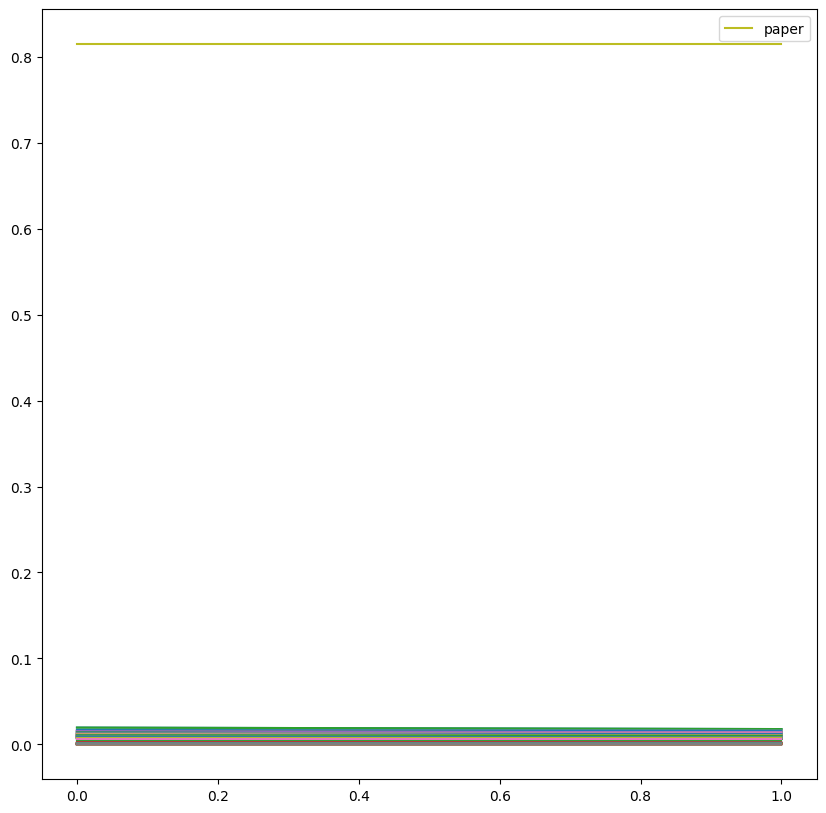

 11%|█         | 14/128 [36:30<4:57:20, 156.49s/it]


KeyboardInterrupt: 

In [41]:
scores = dict()

for name in datasets.keys():
    scores[name] = []

for k in range(30, 500) :
    for name, data in tqdm(datasets.items()):
        LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))
        y_pred = LOF.fit_predict(data)
        y_pred = list(map(lambda x: {-1:1, 1:0}[x], y_pred))
        scores[name].append(score(y_pred, y_test))


    clear_output(True)
    plt.figure(figsize = (10, 10))
    for name, score_list in scores.items():
        sns.lineplot([k['recall'] for k in score_list])
    sns.lineplot([.81495 for _ in range(30, k+1)], label = 'paper')
    plt.show()